In [1]:
import numpy as np 
import os
import pandas as pd 
from scipy.io import wavfile

import librosa
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from tensorflow.keras import regularizers, activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from datetime import datetime 

from matplotlib import pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
us8k_df = pd.read_pickle("us8k_df.pkl")

In [4]:
df = us8k_df.drop(['fold'],axis=1)
df['melspectrogram'][0]

array([[-61.70703 , -74.49714 , -65.133354, ..., -80.      , -80.      ,
        -80.      ],
       [-58.9729  , -65.05351 , -65.055664, ..., -80.      , -80.      ,
        -80.      ],
       [-58.314186, -59.996964, -61.480446, ..., -80.      , -80.      ,
        -80.      ],
       ...,
       [-80.      , -80.      , -67.451935, ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -74.46571 , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

In [5]:
X = np.stack(df.melspectrogram.to_numpy())

In [6]:
X.shape
X_dim = (128,128,1)

In [7]:
X = X.reshape(X.shape[0], *X_dim)

In [8]:
Y = np.array(df['label'])

In [9]:
Y = to_categorical(Y)

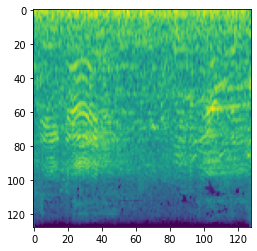

In [10]:
plt.imshow(X[1])

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,shuffle=True,stratify = Y)
len(X_train),len(X_test),len(Y_test)
X_val, X_test, Y_val,Y_test = train_test_split(X_test,Y_test,test_size=0.5,shuffle=True,stratify = Y_test)
len(X_test)

1310

In [12]:
def init_model():
    model1 = Sequential()
    
    #layer-1
    model1.add(Conv2D(filters=24, kernel_size=5, input_shape=(128, 128, 1),
                      kernel_regularizer=regularizers.l2(1e-3)))
    model1.add(MaxPooling2D(pool_size=(3,3), strides=3))
    model1.add(Activation(activations.relu))
    
    #layer-2
    model1.add(Conv2D(filters=36, kernel_size=4, padding='valid', kernel_regularizer=regularizers.l2(1e-3)))
    model1.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model1.add(Activation(activations.relu))
    
    #layer-3
    model1.add(Conv2D(filters=48, kernel_size=3, padding='valid'))
    model1.add(Activation(activations.relu))
    
    model1.add(GlobalAveragePooling2D())
    
    #layer-4 (1st dense layer)
    model1.add(Dense(60, activation='relu'))
    model1.add(Dropout(0.5))
    
    #layer-5 (2nd dense layer)
    model1.add(Dense(10, activation='softmax'))

    
    # compile
    model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model1

In [13]:
def process(model,X_train,X_val,Y_train,Y_val, epochs=100, num_batch_size=32):
    
    # init model
    model = init_model()

    # pre-training accuracy
    score = model.evaluate(X_val, Y_val, batch_size=num_batch_size, verbose=0)
    print("Pre-training accuracy: %.4f%%\n" % (100 * score[1]))
    
    # train the model
    start = datetime.now()
    history = model.fit(X_train,Y_train, epochs=epochs,validation_data=(X_val,Y_val),batch_size=num_batch_size)
    end = datetime.now()
    print("Training completed in time: ", end - start, '\n')
    
    return history

In [28]:
model = init_model()

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 124, 124, 24)      624       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 41, 24)        0         
_________________________________________________________________
activation_3 (Activation)    (None, 41, 41, 24)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 38, 38, 36)        13860     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 36)        0         
_________________________________________________________________
activation_4 (Activation)    (None, 19, 19, 36)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 17, 17, 48)       

In [33]:
initial_epochs = 100
num_batch_size = 32
loss0, accuracy0 = model.evaluate(X_val,Y_val)

41/41 [==============================] - 1s 20ms/step - loss: 5.5200 - accuracy: 0.1145


In [32]:
# On va utiliser 2 callback pour assurer un bon suivi
# - tensorboard_callback nous permettra de visualiser des indicateurs sur TensorBoard
# - save_best enregistrera automatiquement le modèle qui performe le mieux sur le set de validation

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)
save_best = tf.keras.callbacks.ModelCheckpoint(filepath = "logs/checkpoints/", save_weights_only = True,
                                               monitor = "val_accuracy", mode = "max", save_best_only = True)

In [34]:
model_fit = model.fit(X_train[:6000],Y_train[0:6000], epochs=initial_epochs,validation_data=(X_val[0:900],Y_val[0:900]),batch_size=num_batch_size,callbacks = [tensorboard_callback, save_best])


Epoch 1/100
188/188 [==============================] - 15s 80ms/step - loss: 2.3663 - accuracy: 0.1142 - val_loss: 2.2774 - val_accuracy: 0.1122
Epoch 2/100
188/188 [==============================] - 15s 79ms/step - loss: 2.1750 - accuracy: 0.1955 - val_loss: 1.9243 - val_accuracy: 0.3167
Epoch 3/100
188/188 [==============================] - 15s 79ms/step - loss: 1.8558 - accuracy: 0.3143 - val_loss: 1.5953 - val_accuracy: 0.4156
Epoch 4/100
188/188 [==============================] - 15s 80ms/step - loss: 1.6681 - accuracy: 0.3890 - val_loss: 1.4910 - val_accuracy: 0.4589
Epoch 5/100
188/188 [==============================] - 15s 80ms/step - loss: 1.5427 - accuracy: 0.4373 - val_loss: 1.4928 - val_accuracy: 0.4856
Epoch 6/100
188/188 [==============================] - 15s 81ms/step - loss: 1.4716 - accuracy: 0.4677 - val_loss: 1.2635 - val_accuracy: 0.5511
Epoch 7/100
188/188 [==============================] - 15s 80ms/step - loss: 1.4012 - accuracy: 0.4972 - val_loss: 1.1473 - val_ac

In [35]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

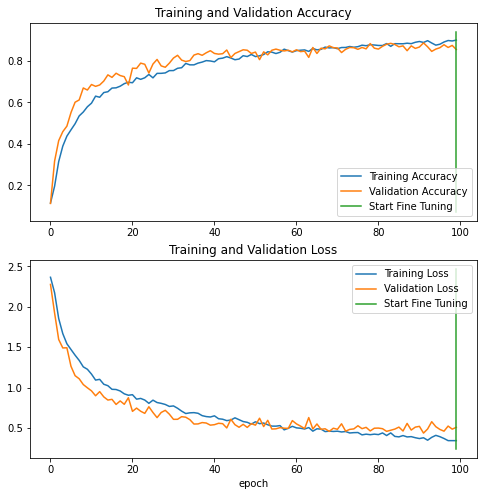

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
loss, accuracy = model.evaluate(X_test,Y_test)
loss, accuracy1 = model.evaluate(X_train,Y_train)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)

191/191 [==============================] - 4s 18ms/step - loss: 0.2636 - accuracy: 0.9267
Test accuracy : 0.85267174243927
Train accuracy : 0.926701545715332


In [42]:
model.save('logs/soundClass_model.h5')

In [54]:
%tensorboard  --logdir=logs/fit

In [53]:
%load_ext tensorboard